# Credit Sesame Sr. Data Scientist Take Home
By Isaac Golberg  
Last Edited: October 3, 2021

## Goal

Build a model to predict the likelihood of default, a model which can generalize to other data points.

## Data
This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

#### Content

There are 25 variables:

ID: ID of each client  
LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit  
SEX: Gender (1=male, 2=female)  
EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others)  
MARRIAGE: Marital status (1=married, 2=single, 3=others)  
AGE: Age in years  
PAY_1: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two   months, … 8=payment delay for eight months, 9=payment delay for nine months and above)  
PAY_2: Repayment status in August, 2005 (scale same as above)  
PAY_3: Repayment status in July, 2005 (scale same as above)  
PAY_4: Repayment status in June, 2005 (scale same as above)  
PAY_5: Repayment status in May, 2005 (scale same as above)  
PAY_6: Repayment status in April, 2005 (scale same as above)  
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)  
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)  
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)  
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)  
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)  
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)  
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)  
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)  
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)  
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)  
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)  
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)  
default payment next month: Default payment (1=yes, 0=no), has been renamed to DEFAULT    

##### Import necessary libraries

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline

##### Read in dataset and change column name as it seems to be an error and change default payment next month to easier label

In [4]:
path = '/Users/isaacgolberg/Desktop/Credit Sesame - Take Home/default of credit card clients.xls'
df = pd.read_excel(path, header = 1).rename(columns={'PAY_0': 'PAY_1', 'default payment next month': 'DEFAULT'})

In [5]:
df_copy = df.copy()

In [6]:
pd.set_option('display.max_columns', None)
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Exploratory Analysis

In [7]:
df.shape

(30000, 25)

##### Check for null values

In [8]:
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64

In [9]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


By generating some high level statistics, we are able to get a general idea of the distribution of the different variables. We also notice the following:  
 - The description of the dataset stated that Education can take on the values 1,2,3, and 4, but we see that the minimum is 0 and the maximum is 6
 - The description of the dataset stated that Marriage can take on the values 1,2, and 3, but we see that the minimum is 0
 - The description of the dataset stated that all pay columns can take on the values -1, 1, 2, ..., 8, and 9, but we see that the pay columns in our dataset have a minimum value of -2 and a maximum value 8
 - The averages of the Bill Amount columns are decreasing which implies that the average amount for the Bill Statement is increasing month over month
 - Negative values can be seen in the Bill Amounts columns which may imply that individuals can receive credit.  

We will continue exploring the dataset and mentioned concerns will be handled with preprocessing. 

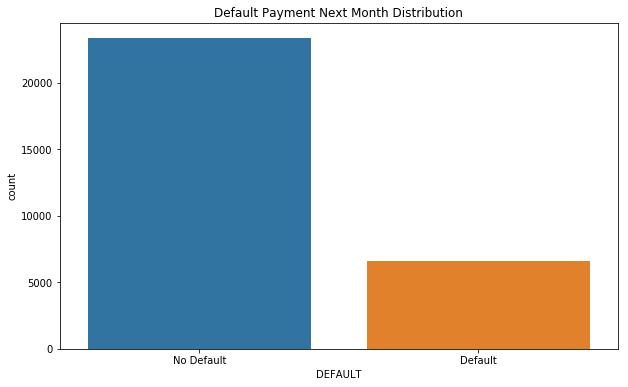

In [10]:
ax = plt.figure(figsize=(10, 6))
ax = sns.countplot(x='DEFAULT', data=df)
ax.set_title('Default Payment Next Month Distribution')
ax.set_xticklabels(['No Default', 'Default'])
plt.show()

The graph above shows that our Target variable does not have an even distribution between the classes. This means we will need to be cautious when evaluating model performance as accuracy may not be a trustworthy metric. 

Lets take a look at the default breakdown with respect to Limit Amount, Sex, Education, Marriage, and Age.

In [11]:
no_default = df[df['DEFAULT'] == 0]
default = df[df['DEFAULT'] == 1]

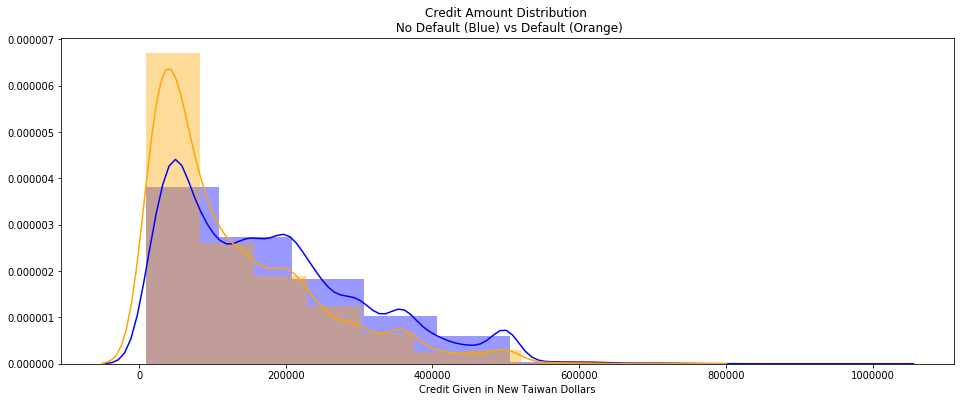

In [12]:
ax = plt.figure(figsize=(16, 6))
ax = sns.distplot(no_default['LIMIT_BAL'], bins=10, color='blue')
ax = sns.distplot(default['LIMIT_BAL'], bins=10, color='orange')
ax.set_title('Credit Amount Distribution \n No Default (Blue) vs Default (Orange)')
plt.xlabel('Credit Given in New Taiwan Dollars')
plt.show()

Above, we see that customers with lower amounts of credit seem to default more frequently. This could imply that the initial benchmarks that are used to decide if a client will receive credit or not may not be rigorous enough. 

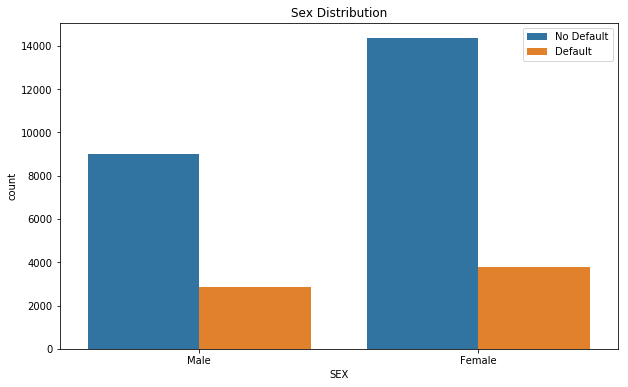

In [13]:
ax = plt.figure(figsize=(10, 6))
ax = sns.countplot(x='SEX', data=df, hue='DEFAULT')
ax.set_title('Sex Distribution')
ax.set_xticklabels(['Male', 'Female'])
ax.legend(labels=['No Default', 'Default'])
plt.show()

It seems like females have a higher probability of default. There could be additional interactions that explain this so we cannot definitively draw the conclusion.

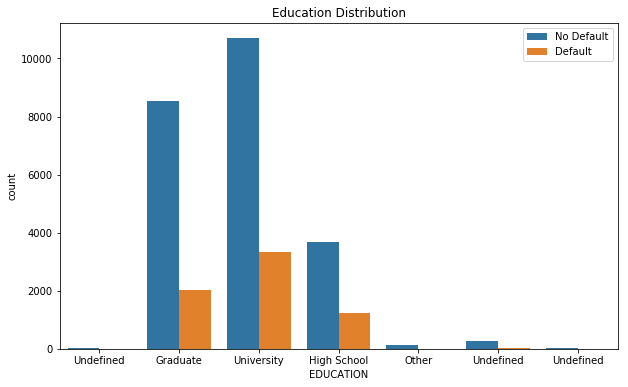

In [14]:
ax = plt.figure(figsize=(10, 6))
ax = sns.countplot(x='EDUCATION', data=df, hue='DEFAULT')
ax.set_title('Education Distribution')
ax.set_xticklabels(['Undefined', 'Graduate', 'University', 
                    'High School', 'Other', 'Undefined', 'Undefined'])
ax.legend(labels=['No Default', 'Default'])
plt.show()

As mentioned earlier, we will need to address the issue of the Undefined classes in the preprocessing steps. We can see from the graph that as education level increases, the likelihood of default decreases (excluding the other and undefined categories).

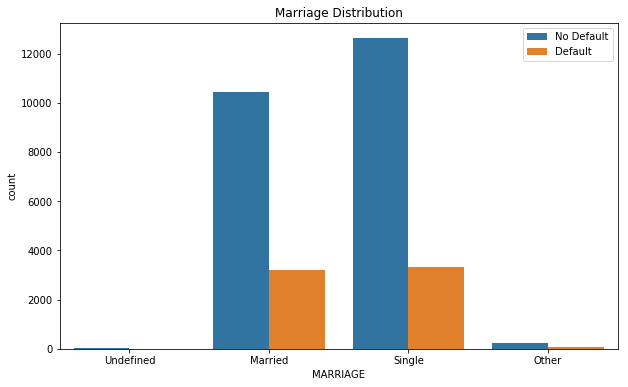

In [15]:
ax = plt.figure(figsize=(10, 6))
ax = sns.countplot(x='MARRIAGE', data=df, hue='DEFAULT')
ax.set_title('Marriage Distribution')
ax.set_xticklabels(['Undefined', 'Married', 'Single', 'Other'])
ax.legend(labels=['No Default', 'Default'])
plt.show()

We can see that married individuals are more likely to default than single people. The Other category is the most likely to default out of all of them, but there are not many samples in that group. We will need to address the Undefined group in the preprocessing.

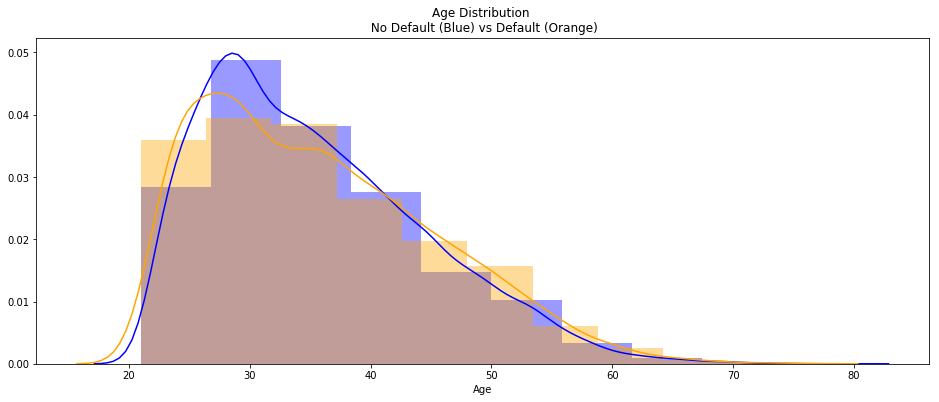

In [16]:
ax = plt.figure(figsize=(16, 6))
ax = sns.distplot(no_default['AGE'], bins=10, color='blue')
ax = sns.distplot(default['AGE'], bins=10, color='orange')
ax.set_title('Age Distribution \n No Default (Blue) vs Default (Orange)')
plt.xlabel('Age')
plt.show()

Individuals under the age of ~29 are more likely to default than individuals that are between 30-41. After 41 the likelihood of defaulting seems to increase.

Now we will look at the PAY columns. First, we will define a function to visualize all of the PAY columns.

In [17]:
def draw_histograms(df, variables, n_rows, n_cols):
    """Generate histograms and format properly."""
    fig = plt.figure(figsize=(12, 8))
    for i, var in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        sns.countplot(x=var, data=df, hue='DEFAULT', ax=ax)
        ax.set_title(var)
    fig.tight_layout()

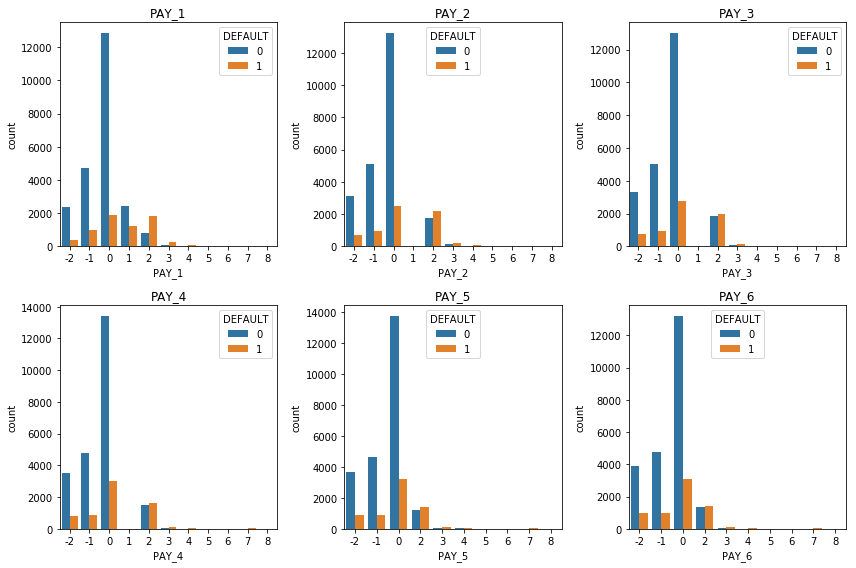

In [18]:
late_pay = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT']]
draw_histograms(late_pay, late_pay.columns[0:-1], 2, 3)

We see from the histograms that the values for the PAY columns do not correspond with the values we are told we would have in the dataset. This could be a scaling issue, a mislabel, or the definitions were simply not provided. Lets see if we can tell a story with some of the records that could give us insight as to the meaning of the undefined values

In [19]:
df[df['PAY_1'] == -2].head(4)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
9,10,20000,1,3,2,35,-2,-2,-2,-2,-1,-1,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0
23,24,450000,2,1,1,40,-2,-2,-2,-2,-2,-2,5512,19420,1473,560,0,0,19428,1473,560,0,0,1128,1
33,34,500000,2,2,1,54,-2,-2,-2,-2,-2,-2,10929,4152,22722,7521,71439,8981,4152,22827,7521,71439,981,51582,0
34,35,500000,1,1,1,58,-2,-2,-2,-2,-2,-2,13709,5006,31130,3180,0,5293,5006,31178,3180,0,5293,768,0


The record with ID 10 has -2 as the values for the first four Payment columns and then -1 for the last 2. The first four columns of Bill Amount have a value of 0 and the first three PAY_AMT columns also have 0. This would imply that in September, August, July, and June the bill amount was 0 and in the months of August, July, and June the customer paid 0 (remember that the PAY_AMT columns are based on the previous month's payment). This leads me to think that a value of -2 for the PAY column may mean that the customer did not owe anything AND he did not make a payment. BILL_AMT5 is equal to PAY_AMT4 which means the customer paid his balance in its entirety. This corresponds to the data definition of -1 for the PAY column. PAY_AMT5 is substantially less than BILL_AMT6, but it is labeled as having -1 in the repayment status. If we assume this to be true, it could be explained by the customer already having a posted credit on his account that covered the remaining difference.  

Following the same procedure for records with ID 24, 34, and 35, we see that our theory about -2 in the PAY column meaning that the customer did not owe anything AND did not make a payment does not work. We see that most of the PAY_AMTs line up with the BILL_AMTs, but there are still records that do not match meaning the customer either overpaid, did not pay in full, or had a credit that is not being reflected in this data which covered the amount.  

Another thing to note is that two of the observations in this table defaulted on their next month's payment (by definition provided). Using the term default is a bit strange to me as the customer with ID 24 was making payments monthly and their most recent payment (PAY_AMT1) was more than the corresponding bill (BILL_AMT2). Typically for an account to default, you must be consistently missing/not making payments. This is called being delinquent and it is not the same as an account defaulting. We saw earlier that the dataset has around 22% of the records labeled as "DEFAULT" in the next month. This seems rather high and I believe it is more likely to mean that the customer missed a payment the following month.  

This procedure of narrative building was done for other records with different values in the PAY columns.


Below we define a function to draw and format distribution plots. We will use this function to visualize the amounts billed and paid.

In [20]:
def draw_distplots(df, variables, n_rows, n_cols, x_low=-20000, x_high=100000):
    """Generate distribution plots and format properly."""
    no_default = df[df['DEFAULT'] == 0]
    default = df[df['DEFAULT'] == 1]
    
    fig = plt.figure(figsize=(16, 24))
    for i, var in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        ax = sns.distplot(no_default[var], bins=100, color='blue')
        ax = sns.distplot(default[var], bins=100, color='orange')
        ax.set_title(var + '\n No Default (Blue) vs Default (Orange)')
        ax.set_xlim(x_low, x_high)
    fig.tight_layout()

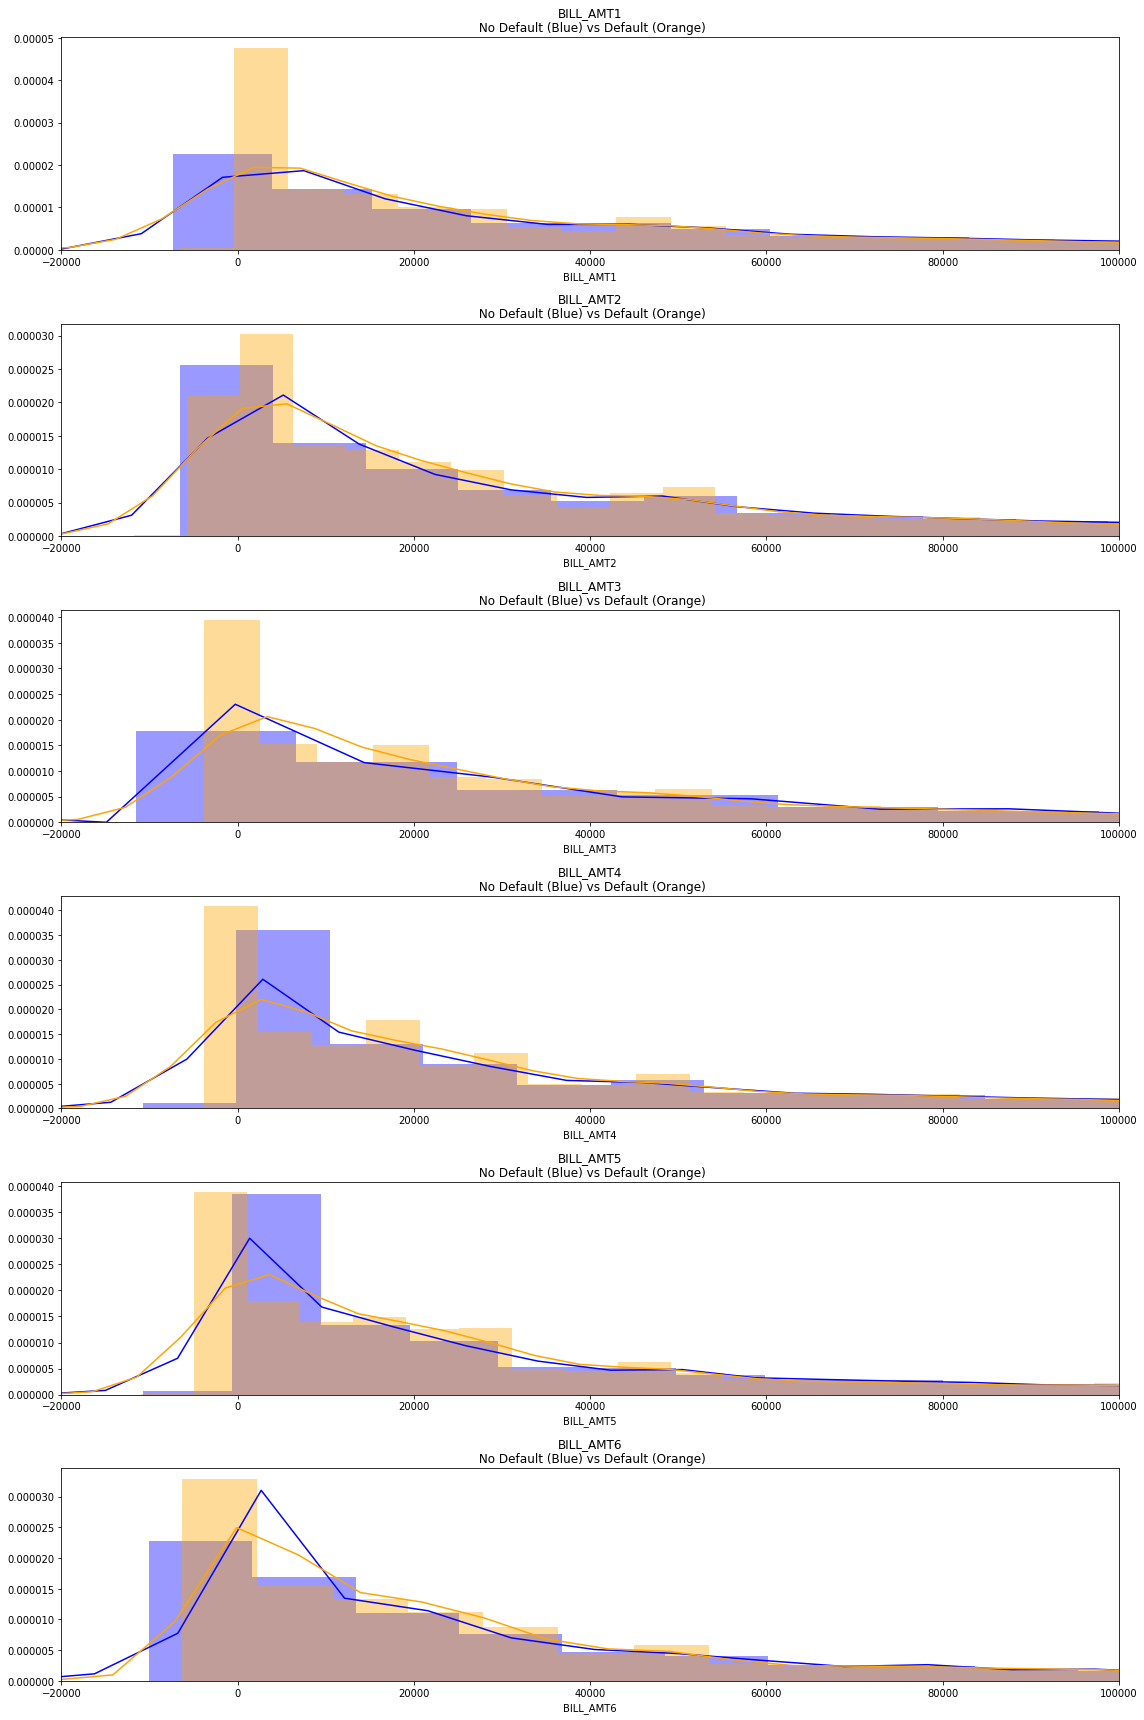

In [21]:
bill_amt = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'DEFAULT']]
draw_distplots(bill_amt, bill_amt.columns[0:-1], 6, 1)

Lets take a look to see if we have bills that are greater than our Credit Limit.

In [22]:
print('Percentage of bills that are greater than the Credit Limit\n')
for col in bill_amt.columns[:-1]:
    print(col)
    bill_over_lim = df[df[col] > df['LIMIT_BAL']]
    print(str(round((bill_over_lim.shape[0]/df.shape[0])*100, 2)) + '%')

Percentage of bills that are greater than the Credit Limit

BILL_AMT1
7.05%
BILL_AMT2
6.47%
BILL_AMT3
5.28%
BILL_AMT4
3.39%
BILL_AMT5
2.73%
BILL_AMT6
2.66%


Of the bills that were higher than the credit limit, lets see what percentage defaulted.

In [23]:
for col in bill_amt.columns[:-1]:
    print('\n')
    print(col)
    bill_over_lim = df[df[col] > df['LIMIT_BAL']]
    print(round(bill_over_lim['DEFAULT'].value_counts(normalize=True) * 100, 2))



BILL_AMT1
0    69.93
1    30.07
Name: DEFAULT, dtype: float64


BILL_AMT2
0    68.45
1    31.55
Name: DEFAULT, dtype: float64


BILL_AMT3
0    69.24
1    30.76
Name: DEFAULT, dtype: float64


BILL_AMT4
0    66.01
1    33.99
Name: DEFAULT, dtype: float64


BILL_AMT5
0    64.27
1    35.73
Name: DEFAULT, dtype: float64


BILL_AMT6
0    64.41
1    35.59
Name: DEFAULT, dtype: float64


Now, lets look at the percentage of default for the overall dataset.

In [24]:
df['DEFAULT'].value_counts(normalize=True) * 100

0    77.88
1    22.12
Name: DEFAULT, dtype: float64

The percentage of customers that default when they spend more than their credit limit is higher than the percentage of individuals that default in our overall dataset.

Lets move on to taking a look at the payment amount columns.

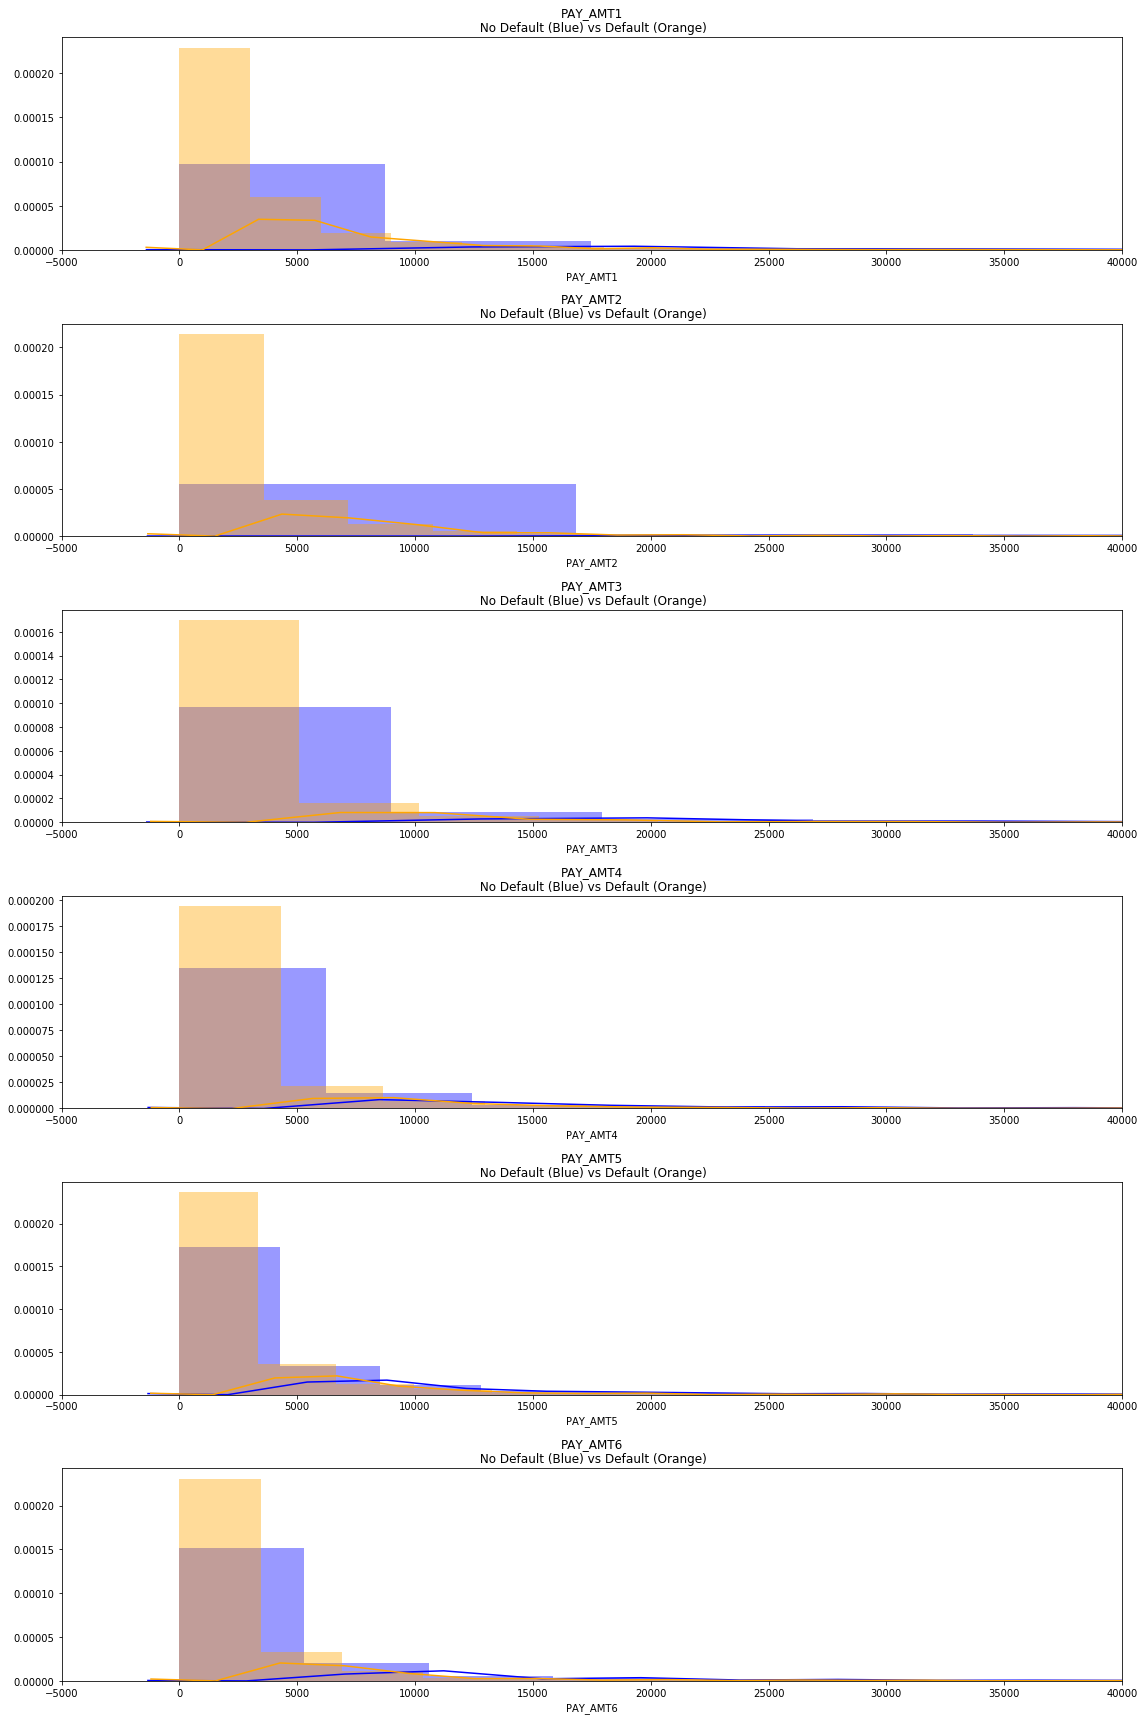

In [25]:
pay_amt = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT']]
draw_distplots(pay_amt, pay_amt.columns[0:-1], 6, 1, x_low=-5000, x_high=40000)

The PAY_AMT charts show us that the customers that are making lower payments are more likely to default/miss their payment.

Now lets take a look at the correlation matrix for the continuous variables.

In [26]:
cont_var = [
    'LIMIT_BAL', 'AGE', 'BILL_AMT1', 
    'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 
    'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 
    'PAY_AMT5', 'PAY_AMT6'
    ]

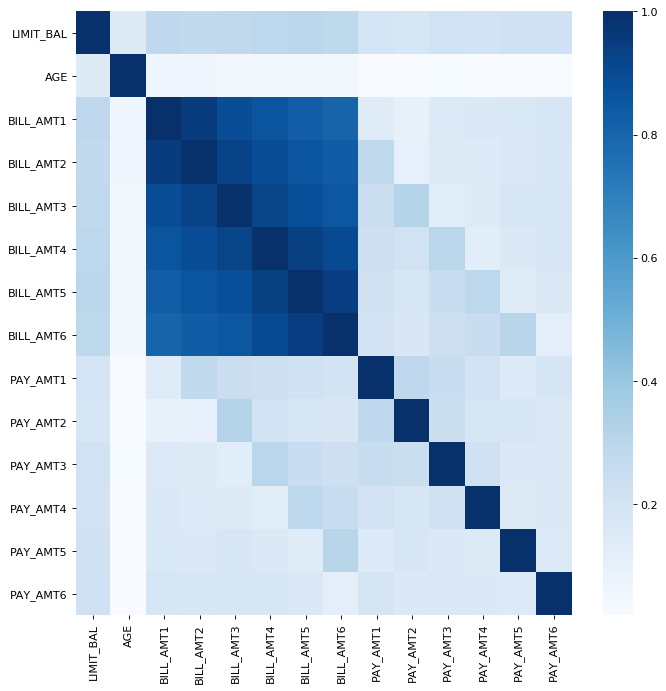

In [27]:
df_corr = df[cont_var].corr()

plt.figure(figsize=(10, 10), dpi=80)
sns.heatmap(df_corr, cmap='Blues')

The correlation matrix shows us that the BILL_AMT variables are highly correlated.

## Data Cleaning

#### Education

Below we look at the distribution of the different categories for the Education column to see how we should treat the undefined classes.

In [28]:
precount_ed = pd.DataFrame(df.groupby(df['EDUCATION'])['ID'].size())
precount_ed

,ID
EDUCATION,
0,14
1,10585
2,14030
3,4917
4,123
5,280
6,51


In [29]:
precount_ed_def = pd.DataFrame(df.groupby([df['EDUCATION'], 
                                           df['DEFAULT']]).size().unstack())
precount_ed_def

DEFAULT,0,1
EDUCATION,,
0,14.0,NaN
1,8549.0,2036.0
2,10700.0,3330.0
3,3680.0,1237.0
4,116.0,7.0
5,262.0,18.0
6,43.0,8.0


In [30]:
df[~df['EDUCATION'].isin([1,2,3,4])]['EDUCATION'].count()

345

Our options for handling these undetermined categories is to either remove them entirely, bucket them with the "Other" category, or generate a new category that buckets these observations into an "Undefined" group. We will combine the variables into the "Other" category since there could be many different levels of education.

In [31]:
defined_edu = [1, 2, 3]
df.loc[:, 'EDUCATION'] = df.loc[:, 'EDUCATION'].apply(lambda edu: 
                                                      4 if edu not in defined_edu else edu)

In [32]:
postcount_ed = pd.DataFrame(df.groupby(df['EDUCATION']).size())
postcount_ed

,0
EDUCATION,
1,10585
2,14030
3,4917
4,468


#### Marriage

Now we will look at the different categories for the Marriage column to see how we should treat the undefined class.

In [33]:
precount_marr = pd.DataFrame(df.groupby(df['MARRIAGE']).size())
precount_marr

,0
MARRIAGE,
0,54
1,13659
2,15964
3,323


In [34]:
precount_marr_def = pd.DataFrame(df.groupby([df['MARRIAGE'], 
                                             df['DEFAULT']]).size().unstack())
precount_marr_def

DEFAULT,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


Using the same reasoning as for the Education column, we will change records with a 0 in the Marriage column to have a 3 denoting the "Other" colunmn.

In [35]:
df.loc[:, 'MARRIAGE'] = df.loc[:, 'MARRIAGE'].apply(lambda marriage: 3 if marriage == 0 else marriage)

In [36]:
postcount_marr = pd.DataFrame(df.groupby(df['MARRIAGE']).size())
postcount_marr

,0
MARRIAGE,
1,13659
2,15964
3,377


#### PAY Columns

Next, we will move on to the PAY columns. These columns have values that range from -2 to 8, but the definitions state that values should range from -1 to 9.

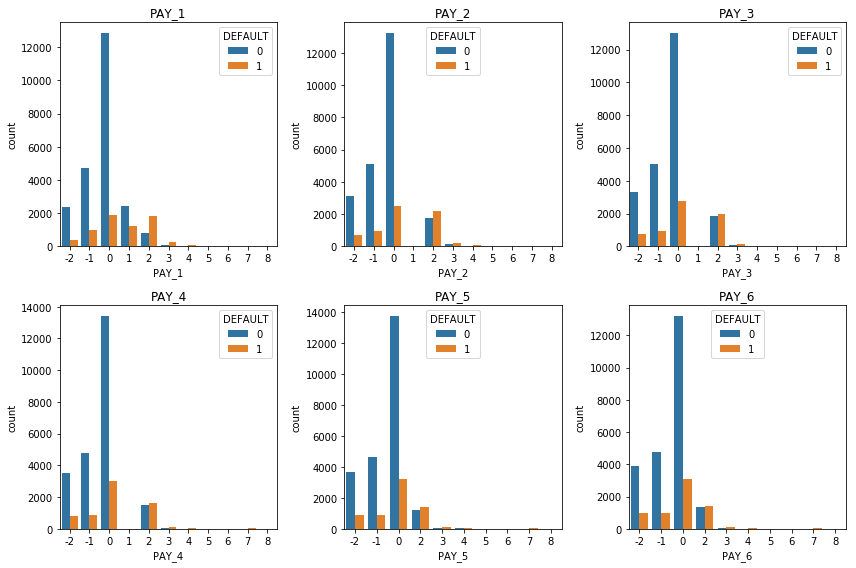

In [37]:
late_pay = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT']]
draw_histograms(late_pay, late_pay.columns[0:-1], 2, 3)

Now lets display all the unique values for each PAY column.

In [38]:
for col in df.columns[6:12]:
    print(col, sorted(df[col].unique()))

PAY_1 [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_2 [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_3 [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_4 [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_5 [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]
PAY_6 [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]


After visualizing the PAY variables and trying to build a cohesive story from the observations, it is difficult to determine a conclusive and sound way of interpreting these variables. We will leave them as is for now.

### Drop ID column

In [39]:
df.drop(['ID'], inplace=True, axis=1)

## Preprocessing

### Dummy Encode Categorical Variables

For interpretability and ease, I will use the pandas get_dummies method while I am experimenting with different models. Once we pick a best model, we can build a pipeline with scikitlearn OneHotEncoder as to not miss any classes when using it on train/test data.

In [40]:
df = pd.concat([pd.get_dummies(df['SEX'], drop_first=True, prefix='SEX'), 
              pd.get_dummies(df['EDUCATION'], drop_first=True, prefix='EDUCATION'), 
              pd.get_dummies(df['MARRIAGE'], drop_first=True, prefix='MARRIAGE'),
              df],axis=1)

df.drop(['SEX', 'EDUCATION', 'MARRIAGE'], inplace=True, axis=1)
df.head(5)

,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,1,0,0,0,0,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,1,1,0,0,1,0,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,1,1,0,0,1,0,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,1,1,0,0,0,0,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,0,1,0,0,0,0,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Scale Continuous Data

We will be testing different algorithms to see how they perform. Algorithms that use weighted sums (e.g. glms) and algorithms that use distance measures perform much better when continuous data is scaled.  

The data must be split into training and test data first as scaling the data will be skewed if it is done on the entirety of the dataset.

In [41]:
df.head()

,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,1,0,0,0,0,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,1,1,0,0,1,0,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,1,1,0,0,1,0,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,1,1,0,0,0,0,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,0,1,0,0,0,0,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [42]:
y = df['DEFAULT']
X = df.drop(['DEFAULT'], axis=1)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

In [44]:
col_names = [
    'LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 
    'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
    'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
    ]

features_train = X_train.loc[:, col_names]
features_test = X_test.loc[:, col_names]

scaler = StandardScaler().fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)

X_train.loc[:, col_names] = features_train
X_test.loc[:, col_names] = features_test

/Users/isaacgolberg/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Handle Collinearity with PCA  
As noted earlier, the BILL_AMT variables were very correlated. PCA will be used to address this issue. However, we will also save a copy of the data at this point before running PCA as one of the downsides of this method is that we lose interpretability. 

In [45]:
# Retain copies of the data
X_train_pca = X_train.copy()
X_test_pca = X_test.copy()

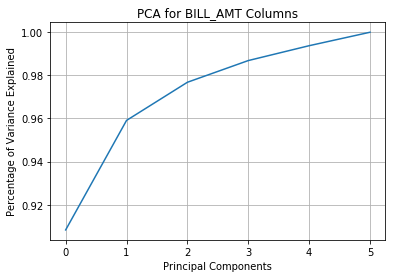

In [46]:
bill_col = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# Run PCA on the BILL_AMT columns
pca = PCA(n_components = len(bill_col))
pca_data = pca.fit_transform(X_train_pca.loc[:, bill_col])

# Calculate how much of the variance is explained for each principal component
percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

# Plot the calculated numbers
plt.title('PCA for BILL_AMT Columns')
plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Variance Explained')
plt.show()

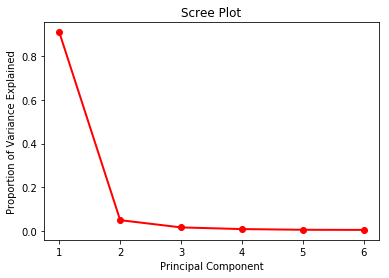

In [47]:
# Generate a Scree Plot to decide how many principal components to use
pc_values = np.arange(pca.n_components_) + 1
plt.plot(pc_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

From the Scree Plot we can confidently say that two principal components capture most of the variance. Lets replace the BILL_AMT columns with the first two principal components. Again, we must fit on the training data as the test data is "unseen" data.

In [48]:
# Use 2 Principal Components to capture the information from the BILL_AMT columns
pca = PCA(n_components=2)
pca_train_bill = pca.fit_transform(X_train_pca[bill_col])
pca_test_bill = pca.transform(X_test_pca[bill_col])

pca_train = pd.DataFrame(pca_train_bill, columns=['PCA_bill_1', 'PCA_bill_2']).reset_index(drop=True)
pca_test = pd.DataFrame(pca_test_bill, columns=['PCA_bill_1', 'PCA_bill_2']).reset_index(drop=True)

# Append the Principal Components to our feature datasets
X_train_pca = pd.concat([X_train_pca, pca_train.set_index(X_train_pca.index)], axis=1)
X_test_pca = pd.concat([X_test_pca, pca_test.set_index(X_test_pca.index)], axis=1)

# Remove the BILL_AMT columns as PCA has now captured this information
X_train_pca.drop(bill_col, inplace=True, axis=1)
X_test_pca.drop(bill_col, inplace=True, axis=1)

## Modeling

We will test different models using cross validation and a grid search to select the best parameters. The models will be scored on their F1 Score as accuracy will not necessarily provide an good metric for evaluation.

In [49]:
def cross_val(model, grid, X_train):
    """
    Run Stratified K Fold Validation and use 
    a grid search to determine the best model parameters.
    Return the best model parameters based on F1 Score.
    """
    # Run cross validation and a grid search to determine best parameters
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=123)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, 
                               n_jobs=-1, cv=cv, scoring='f1',
                               error_score=0)
    grid_result = grid_search.fit(X_train, y_train)

    # Summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    return grid_result.best_params_

def confusion_matrix(model, X_test, y_test, predictions):
    """Visualize model performance with a confusion matrix."""
    # Generate and display confusion matrix
    cm = metrics.confusion_matrix(y_test, predictions)
    score = model.score(X_test, y_test)
    
    plt.figure(figsize = (9,9))
    sns.heatmap(cm, annot = True, fmt = ".3f", linewidths=0.5, square=True, cmap='Blues_r', 
                xticklabels = ['Not Default', 'Default'],
                yticklabels = ['Not Default', 'Default'])
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}%'.format(round(score*100, 2))
    plt.title(all_sample_title, size=15);

### Logistic Regression

In [50]:
# Define models and parameters
lr = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# Define grid search and cross validate to get best model
grid_lr = dict(solver=solvers, penalty=penalty, C=c_values)
best_params_lr = cross_val(lr, grid_lr, X_train_pca)

Best: 0.366528 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.366421 (0.011860) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.366400 (0.011808) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.366400 (0.011808) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.366421 (0.011860) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.366421 (0.011860) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.366400 (0.011808) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.366440 (0.011854) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.366440 (0.011854) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.366528 (0.011727) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.364700 (0.010964) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.364527 (0.010958) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.366190 (0.011994) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.348741 (0.013450) wit

In [51]:
# Fit logistic regression model with best parameters
lr = LogisticRegression(**best_params_lr)
lr.fit(X_train_pca, y_train)

# Generate predictions
predictions_lr = lr.predict(X_test_pca)

# Check Accuracy
score_lr = lr.score(X_test_pca, y_test)
print(score_lr)

0.8137777777777778


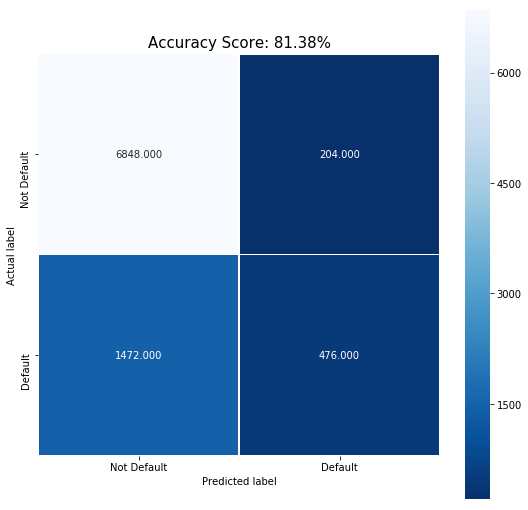

In [52]:
# Generate and display confusion matrix
confusion_matrix(lr, X_test_pca, y_test, predictions_lr)

### Support Vector Machine

In [53]:
# Define models and parameters
svm = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1]
gamma = ['scale']

# Define grid search and cross validate to get best model
grid_svm = dict(kernel=kernel, C=C, gamma=gamma)
best_params_svm = cross_val(svm, grid_svm, X_train_pca)

Best: 0.462815 using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.430742 (0.009552) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.455690 (0.010368) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.277994 (0.018887) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.419716 (0.011214) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.462815 (0.012062) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.277741 (0.018805) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.370565 (0.008698) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.460459 (0.011225) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.273313 (0.017559) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.273614 (0.014803) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.444005 (0.012301) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.278923 (0.014511) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}


In [54]:
# Fit svm model with best parameters
svm = SVC(**best_params_svm)
svm.fit(X_train_pca, y_train)

# Generate predictions
predictions_svm = svm.predict(X_test_pca)

# Check Accuracy
score_svm = svm.score(X_test_pca, y_test)
print(score_svm)

0.8178888888888889


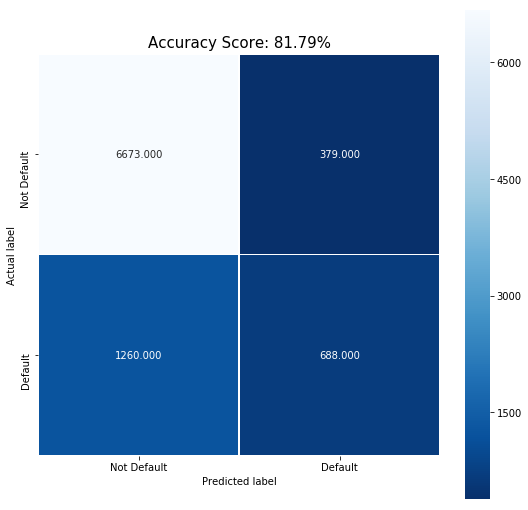

In [55]:
# Generate and display confusion matrix
confusion_matrix(svm, X_test_pca, y_test, predictions_svm)

### Random Forest

In [56]:
# Define models and parameters
rf = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

# Define grid search and cross validate to get best model
grid_rf = dict(n_estimators=n_estimators, max_features=max_features)
best_params_rf = cross_val(rf, grid_rf, X_train_pca)

Best: 0.487039 using {'max_features': 'sqrt', 'n_estimators': 1000}
0.435894 (0.010850) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.483758 (0.009948) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.487039 (0.012486) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.438903 (0.012078) with: {'max_features': 'log2', 'n_estimators': 10}
0.483700 (0.011704) with: {'max_features': 'log2', 'n_estimators': 100}
0.486895 (0.013525) with: {'max_features': 'log2', 'n_estimators': 1000}


In [57]:
# Fit Random Forest model with best parameters
rf = RandomForestClassifier(**best_params_rf)
rf.fit(X_train_pca, y_train)

# Generate predictions
predictions_rf = rf.predict(X_test_pca)

# Check Accuracy
score_rf = rf.score(X_test_pca, y_test)
print(score_rf)

0.8166666666666667


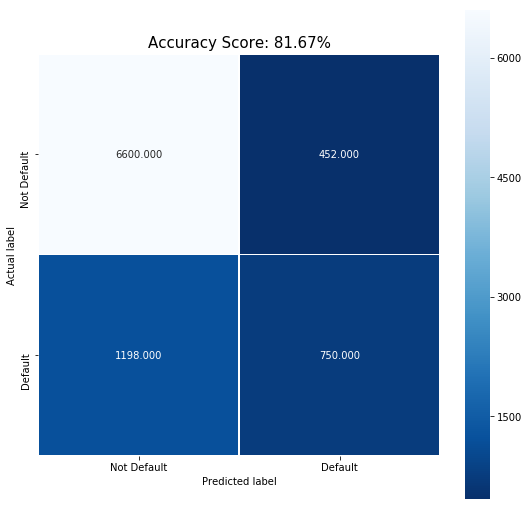

In [58]:
# Generate and display confusion matrix
confusion_matrix(rf, X_test_pca, y_test, predictions_rf)

### Random Forest without PCA

In [59]:
# Define models and parameters
rf_nopca = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

# Define grid search
grid_rf = dict(n_estimators=n_estimators, max_features=max_features)
best_params_rf_nopca = cross_val(rf_nopca, grid_rf, X_train)

Best: 0.481930 using {'max_features': 'log2', 'n_estimators': 1000}
0.434380 (0.017140) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.479441 (0.011963) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.479945 (0.013021) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.431739 (0.012508) with: {'max_features': 'log2', 'n_estimators': 10}
0.476604 (0.013332) with: {'max_features': 'log2', 'n_estimators': 100}
0.481930 (0.012688) with: {'max_features': 'log2', 'n_estimators': 1000}


In [60]:
# Fit rf model with best parameters
rf_nopca = RandomForestClassifier(**best_params_rf_nopca)
rf_nopca.fit(X_train, y_train)

# Generate predictions
predictions_rf_nopca = rf_nopca.predict(X_test)

# Check Accuracy
score_rf_nopca = rf_nopca.score(X_test, y_test)
print(score_rf_nopca)

0.8164444444444444


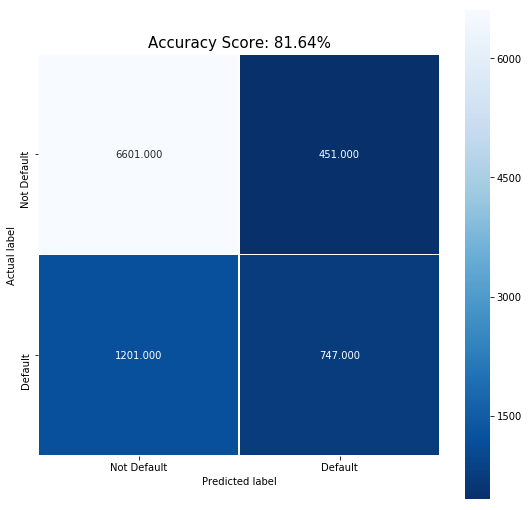

In [61]:
# Generate and display confusion matrix
confusion_matrix(rf_nopca, X_test, y_test, predictions_rf_nopca)

In [62]:
# Print model performance metrics to compare side by side
target_names = ['No Default', 'Default']

print('\nLogistic Regression')
print(metrics.classification_report(y_test, predictions_lr, target_names=target_names))

print('\nSupport Vector Machine')
print(metrics.classification_report(y_test, predictions_svm, target_names=target_names))

print('\nRandom Forest')
print(metrics.classification_report(y_test, predictions_rf, target_names=target_names))

print('\nRandom Forest without PCA')
print(metrics.classification_report(y_test, predictions_rf_nopca, target_names=target_names))


Logistic Regression
              precision    recall  f1-score   support

  No Default       0.82      0.97      0.89      7052
     Default       0.70      0.24      0.36      1948

    accuracy                           0.81      9000
   macro avg       0.76      0.61      0.63      9000
weighted avg       0.80      0.81      0.78      9000


Support Vector Machine
              precision    recall  f1-score   support

  No Default       0.84      0.95      0.89      7052
     Default       0.64      0.35      0.46      1948

    accuracy                           0.82      9000
   macro avg       0.74      0.65      0.67      9000
weighted avg       0.80      0.82      0.80      9000


Random Forest
              precision    recall  f1-score   support

  No Default       0.85      0.94      0.89      7052
     Default       0.62      0.39      0.48      1948

    accuracy                           0.82      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg  

If I had to select a best model out of the ones that we have tested, I would select the Random Forest model. Going just by accuracy, one may think that they all performed about the same way, but looking at the other performance metrics tells us a different story. To decide on which model to select, we must think back to our business use for this model. I believe that having more False Positives is worth it if we can increase the amount of accurate predictions made for the Default class. By identifying customers at risk of Default preemptively, we can provide advice as to steps they can take to remedy the situation and decrease their likelihood of default. Providing suggestions to a customer that actually is not at risk of defaulting does not provide significant negative consequences. Therefore, we prefer a model with higher recall and may be willing to give up some of the precision. Also, looking at F1 Score the random forest model performs slightly better than the others.  

If we look at the Random Forest model performance with PCA versus the Random Forest model without PCA, the performance metrics are nearly identical. The upside of not using PCA is that we have a bit more interpretability and could potentially provide the customer with better recommendations as to how to avoid default.

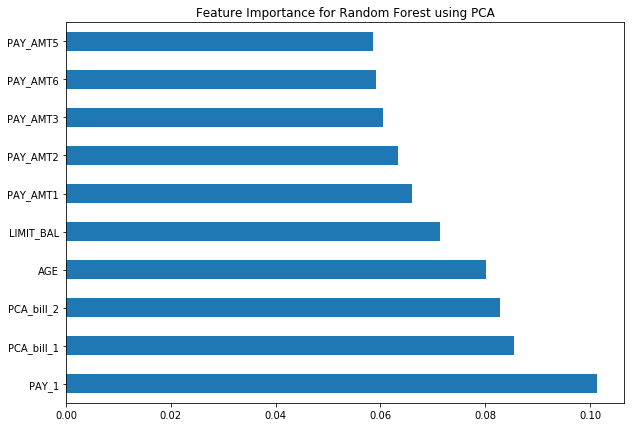

In [63]:
# Display a chart for feature importance using the Random Forest model and PCA
plt.figure(figsize=(10,7))
feat_importances = pd.Series(rf.feature_importances_, index=X_train_pca.columns)
plt.title('Feature Importance for Random Forest using PCA')
feat_importances.nlargest(10).plot(kind='barh');

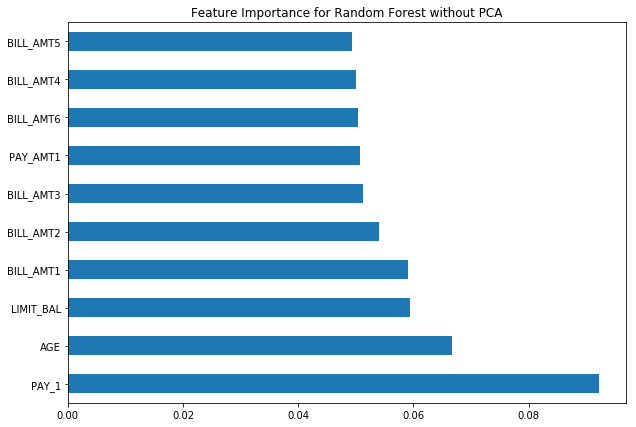

In [64]:
# Display a chart for feature importance using the Random Forest model without PCA
plt.figure(figsize=(10,7))
feat_importances_nopca = pd.Series(rf_nopca.feature_importances_, index=X_train.columns)
plt.title('Feature Importance for Random Forest without PCA')
feat_importances_nopca.nlargest(10).plot(kind='barh');

Now, lets define a pipeline that will allow us to quickly generalize to new points.

In [65]:
 class FeatureSelector(BaseEstimator, TransformerMixin):
    """This is a custom transformer that extracts columns passed as argument to its constructor."""
    # Class Constructor
    def __init__(self, feature_names):
        self._feature_names = feature_names 
    
    # Return self
    def fit(self, X, y=None):
        return self 
    
    # Return daatframe with specified columns
    def transform(self, X, y=None):
        return X[self._feature_names]

In [66]:
# This Transformer will preprocess the features that had undefined/unknown classes 
class PreProcessor(BaseEstimator, TransformerMixin):
    """
    This is a custom transformer that will preprocess 
    the features EDUCATION and MARRIAGE to handle the 
    undefined and unknown classes.
    """
    def __init__(self, EDUCATION=True, MARRIAGE=True):
        self.EDUCATION = EDUCATION
        self.MARRIAGE = MARRIAGE
    
    # Return self
    def fit( self, X, y=None):
        return self 
    
    # Transform method that groups together unknown classes for education and marriage 
    def transform(self, X, y=None):
        defined_edu = [1, 2, 3]
        X.loc[:, 'EDUCATION'] = X.loc[:, 'EDUCATION'].apply(lambda edu: 
                                                      4 if edu not in defined_edu else edu)
        undefined_marriage = [0]
        X.loc[:, 'MARRIAGE'] = X.loc[:, 'MARRIAGE'].apply(lambda marriage: 
                                                          3 if marriage in undefined_marriage else marriage)
        
        return X

In [67]:
# Categorical features to pass to the categorical pipeline
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

# Numerical features to pass to the numerical pipeline
numerical_features = ['LIMIT_BAL', 'AGE', 'PAY_1', 
                      'PAY_2', 'PAY_3', 'PAY_4', 
                      'PAY_5', 'PAY_6', 'BILL_AMT1', 
                      'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
                      'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 
                      'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 
                      'PAY_AMT5', 'PAY_AMT6']

In [68]:
# Define the steps in the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)), 
                                       ('prepoc', PreProcessor()), 
                                       ('one_hot_encoder', OneHotEncoder(sparse=False))])

# Define the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('std_scaler', StandardScaler())])

# Combine categorical and numerical pipelines
full_pipeline = FeatureUnion(transformer_list=[('categorical_pipeline', categorical_pipeline), 
                                               ('numerical_pipeline', numerical_pipeline)])

In [69]:
# Set the features and the target into different datasets
y = df_copy['DEFAULT']
X = df_copy.drop(['DEFAULT'], axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

# Define the full pipeline and now include the model
full_pipeline_model = Pipeline(steps = [('preprocessing', full_pipeline),
                                        ('model', RandomForestClassifier(**best_params_rf_nopca))])

# Fit the pipeline to the data
full_pipeline_model.fit(X_train, y_train)

/Users/isaacgolberg/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/isaacgolberg/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, Future

Pipeline(memory=None,
         steps=[('preprocessing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('cat_selector',
                                                                  FeatureSelector(feature_names=None)),
                                                                 ('prepoc',
                                                                  PreProcessor(EDUCATION=True,
                                                                               MARRIAGE=True)),
                                                                 ('one_hot_encoder',
                                                                  OneHotEncoder(categorical_features=None,
                                                                                categories=None,
               

The pipeline that has been created can now be used to predict the likelihood of default and can be generalized to other data points.

In [70]:
predictions_prob = full_pipeline_model.predict_proba(X_test)
predictions_prob

/Users/isaacgolberg/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


array([[0.796, 0.204],
       [0.897, 0.103],
       [0.175, 0.825],
       ...,
       [0.777, 0.223],
       [0.694, 0.306],
       [0.384, 0.616]])

As shown above, we can use the pipeline to generate probabilities for predicting likelihood of default and to generalize to other points.

There are still many additional steps that can and should be taken before utilizing any model. First, a better understanding of the underlying data is necessary to accurately determine the proper method of preprocessing that is needed for each column. One clear example is that we left the PAY columns intact. Understanding these columns better would allow us to preprocess them more appropriately. This is especially important for non tree based algorithms and could significantly improve their performance. In addition, feature engineering can be done to improve model performance. Creating new variables based on combinations of variables and interactions can improve performance (especially for non tree based models).  

Moreover, additional algorithms should be tested to evaluate performance. Gradient boosting and neural networks could offer improved performance. We have showed that using a rather basic implementation with minimal feature engineering, we were able to get okay performance metrics. Depending on our business use case, model selection, reward functions, and model performance should be adjusted. For example, if we are okay with more False Positives, we could tune the model to fit this need. 